# ASSIGNMENT 6 - DOCUMENT CLASSIFICATION

Molly Siebecker and Marley Myrianthopoulos

CUNY SPS

DATA 620

Summer 2024

## INTRODUCTION

In this assignment, we use machine learning to create a prediction model to classify documents as spam or not spam. Our test and train datasets will be created from the UC Irvine Machine Learning Repository's [Spambase](http://archive.ics.uci.edu/dataset/94/spambase) dataset. For this assignment we will be loading the data using code provided by UCI, but a copy of the data is in our GitHub repository [here](https://github.com/Marley-Myrianthopoulos/cunysps_data620/tree/main/homework/620_hw6).

In [57]:
# Code provided by UCI to import data

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
spambase = fetch_ucirepo(id=94) 
  
# data (as pandas dataframes) 
X = spambase.data.features 
y = spambase.data.targets 
  
# metadata 
print(spambase.metadata) 
  
# variable information 
print(spambase.variables) 

# Load additional required libraries and data
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


{'uci_id': 94, 'name': 'Spambase', 'repository_url': 'https://archive.ics.uci.edu/dataset/94/spambase', 'data_url': 'https://archive.ics.uci.edu/static/public/94/data.csv', 'abstract': 'Classifying Email as Spam or Non-Spam', 'area': 'Computer Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 4601, 'num_features': 57, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1999, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C53G6X', 'creators': ['Mark Hopkins', 'Erik Reeber', 'George Forman', 'Jaap Suermondt'], 'intro_paper': None, 'additional_info': {'summary': 'The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography...\n\nThe classification task for this dataset is to determine whether a given email is spam or not.\n\t\nOur collecti

## EXPLORATORY DATA ANALYSIS

First, we investigate the layout of the data.

In [58]:
print(X.head())
print(X.shape)

   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
0             0.00            0.00  ...                   0.0 

The `X` data frame provides the feature set (recorded as variables) for 4601 emails (recorded as observations).

In [59]:
print(y.head())
print(y.shape)
print(y.value_counts())

   Class
0      1
1      1
2      1
3      1
4      1
(4601, 1)
Class
0        2788
1        1813
Name: count, dtype: int64


The `y` DataFrame provides the classification for each of the emails represented as observations in `X`. A value of 1 indicates that the email is spam, a value of 0 indicates that the email is not spam. The dataset has 1813 spam emails and 2788 emails that are not spam.

## MODEL CONSTRUCTION

To train our model, we will implement a train test split. Of the original 4601 emails, 500 will be sequestered to be used as the final test set. The remaining 4101 will be the training set.

/Users/marleymyrianthopoulos/.virtualenvs/env_cunysps_data620/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/marleymyrianthopoulos/.virtualenvs/env_cunysps_data620/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/marleymyrianthopoulos/.virtualenvs/env_cunysps_data620/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/marleymyrianthopoulos/.virtualenvs/env_cunysps_data620

   neighbors  accuracy
0          1     0.828


/Users/marleymyrianthopoulos/.virtualenvs/env_cunysps_data620/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/marleymyrianthopoulos/.virtualenvs/env_cunysps_data620/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/marleymyrianthopoulos/.virtualenvs/env_cunysps_data620/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Users/marleymyrianthopoulos/.virtualenvs/env_cunysps_data620

<Axes: xlabel='neighbors', ylabel='accuracy'>

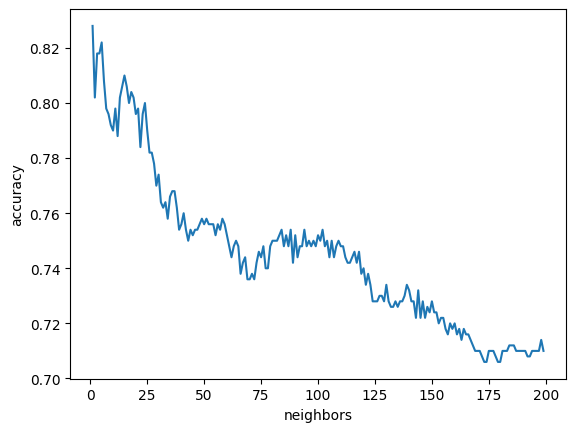

In [60]:
test_ratio_1 = 500 / 4601
X_training, X_test, y_training, y_test = train_test_split(X,
                                                    y,
                                                    test_size = test_ratio_1,
                                                    random_state = 1989)

test_ratio_2 = 500 / 4101
X_train, X_dev_test, y_train, y_dev_test = train_test_split(X_training,
                                                            y_training,
                                                            test_size = test_ratio_2,
                                                            random_state = 1989)

knn_results = []
possible_neighbors = np.arange(1,200)
for n in possible_neighbors:
    model = KNeighborsClassifier(n_neighbors = n)
    model.fit(X_train, y_train)
    knn_results.append(model.score(X_dev_test, y_dev_test))

knn_results = pd.DataFrame({'neighbors': possible_neighbors,
                            'accuracy': knn_results})

print(knn_results[knn_results.accuracy == np.max(knn_results.accuracy)])
sns.lineplot(data = knn_results, x = 'neighbors', y = 'accuracy')

The KNN model has the best results when using only one nearest neighbor. We can now use it to classify the test set.

In [61]:
final_model = KNeighborsClassifier(n_neighbors = 1)
final_model.fit(X_train, y_train)
print(final_model.score(X_test, y_test))


0.816


/Users/marleymyrianthopoulos/.virtualenvs/env_cunysps_data620/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
